# Test the world gen

The following code is a Python implementation of the Perlin noise as is in the Rust code. It should allow to find easily nice parameters before applying them to the code.

## Re-implementation of the code

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Perlin Noise class

Implementation of the Perlin noise for a single scale. The gradient is computed using a seed and the coordinate to have a deterministic noise.

In [20]:
@dataclass
class PerlinNoiseConfig:
    scale: float
    amplitude: float

class PerlinNoise:
    def __init__(self, seed, noise_config):
        self.seed = seed
        self.config = noise_config
        self.gradients = {}

    def closest_corner(self, coord):
        x, y = coord[0] / self.config.scale, coord[1] / self.config.scale
        return np.floor([x, y]).astype(int)

    def get_or_generate_gradient(self, corner):
        if tuple(corner) not in self.gradients:
            np.random.seed(hash((self.seed, tuple(corner))) & 0xFFFFFFFF )
            gradient = np.random.uniform(-1, 1, size=(2,))
            self.gradients[tuple(corner)] = gradient / np.linalg.norm(gradient)
        return self.gradients[tuple(corner)]

    def at(self, coord):
        xc, yc = self.closest_corner(coord)
        corners = np.array([[xc, yc], [xc + 1, yc], [xc, yc + 1], [xc + 1, yc + 1]])

        xr, yr = (coord[0] / self.config.scale - xc, coord[1] / self.config.scale - yc)

        gradients = np.array([self.get_or_generate_gradient(corner) for corner in corners])
        
        a = corners - np.array(coord) / self.config.scale
        b = gradients
        values = np.zeros(len(a))
        for i in range(len(a)): 
          values[i] = np.dot(a[i], b[i])

        return self.config.amplitude * self.lerp(self.fade(yr), self.lerp(self.fade(xr), values[0], values[1]), self.lerp(self.fade(xr), values[2], values[3]))
        

    @staticmethod
    def fade(t):
        return t * t * t * (t * (t * 6 - 15) + 10)

    @staticmethod
    def lerp(t, a, b):
        return a + t * (b - a)

## Multiscale Perlin

In [21]:
class MultiscalePerlinNoise:
    def __init__(self, seed, configs):
        self.seed = seed
        self.perlin_noises = [PerlinNoise(seed + i, configs[i]) for i in range(len(configs))]

    def at(self, coord):
        return sum(self.perlin_noises[i].at(coord) for i in range(len(self.perlin_noises)))

In [82]:
# Function to generate and display a small map using Perlin noise
def generate_map(configs, seed=0, width=100):
    noise_gen = MultiscalePerlinNoise(seed, configs)

    map_data = np.zeros((width, width))
    for i in range(width):
        for j in range(width):
            map_data[i, j] = noise_gen.at([i, j])
            
    return map_data

# CONFIG FOR THE WORLD
width = 200
scales = [64]
amplitudes = [1.0]
normal_amp = 0.5
threshold = 1.2

# Create a list of PerlinNoiseConfig objects
config_list = [PerlinNoiseConfig(scale, amplitude) for scale, amplitude in zip(scales, amplitudes)]

# Example of generating a small map
forest_map = generate_map(config_list, seed=np.random.randint(0,100), width=width)

tree_map = forest_map.copy() + normal_amp * np.random.normal(size=(width, width))

tree_map[tree_map <= threshold] = 0
tree_map[tree_map > threshold] = 1

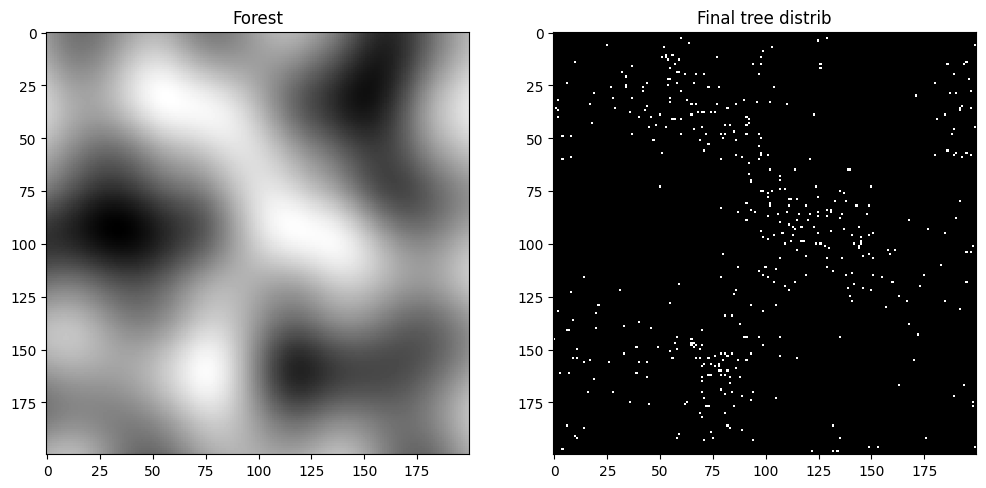

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(forest_map, cmap='gray', interpolation="none")
ax[0].set_title("Forest")

ax[1].imshow(tree_map, cmap='gray', interpolation="none")
ax[1].set_title("Final tree distrib")


plt.show()